# Graph contraction - exact method

In [1]:
import sys
sys.path.insert(0,"..")

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from mcnf import MCNF
from path import Path

First let's define a simple MCNF instance

In [3]:
# simple graph
G = nx.MultiDiGraph()
G.add_edge(1,2,cost=1,capacity=100)
G.add_edge(1,4,cost=1,capacity=100)
G.add_edge(2,3,cost=1,capacity=100)
G.add_edge(4,3,cost=1,capacity=100)
# demands
demands = np.array([[1,3,150]])
# instance 
instance = MCNF(G, demands)

View the instance

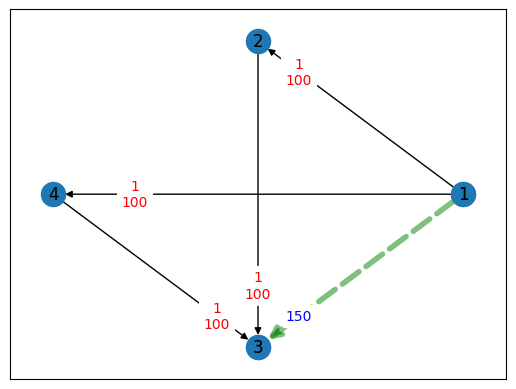

In [4]:
instance.draw(capacity_name="capacity")
plt.show()

Solve the instance

In [5]:
status, solution, solve_t = instance.solve_with_cplex()
print("Solve status : ", status)
print("Solution : ", solution)

Solve status :  optimal
Solution :  [100.  50. 100.  50.]


Get paths used for each demand

In [6]:
paths, flows = instance.solution_paths(solution)
for k, demand in enumerate(demands):
    print("Demand ", k, demand)
    for path, flow in zip(paths[k], flows[k]):
        print("\t", path, flow)

Demand  0 [  1   3 150]
	 Path ([(1, 2, 0), (2, 3, 0)]) 100.0
	 Path ([(1, 4, 0), (4, 3, 0)]) 50.0


View the solution

(<Figure size 640x480 with 1 Axes>,
 [<AxesSubplot:title={'center':'Demand 0: 1->3, d_0=150'}>])

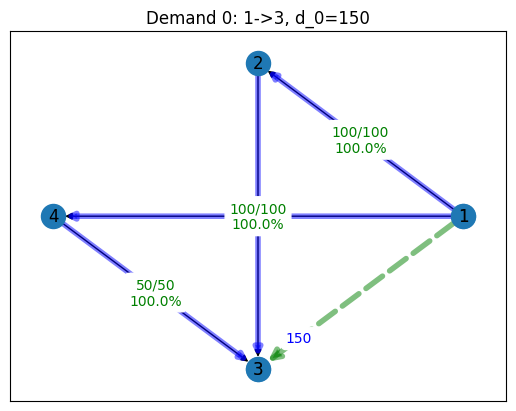

In [7]:
instance.draw_solution(solution)

## Example with contraction of the graph

In [8]:
# simple graph
G = nx.MultiDiGraph()
G.add_edge(5,4,cost=1,bandwidth=200)
G.add_edge(4,3,cost=1,bandwidth=100)
G.add_edge(3,2,cost=1,bandwidth=100)
G.add_edge(4,2,cost=1,bandwidth=100)
G.add_edge(2,1,cost=1,bandwidth=200)
G.add_edge(4,5,cost=1,bandwidth=200)
G.add_edge(3,4,cost=1,bandwidth=100)
G.add_edge(2,3,cost=1,bandwidth=100)
G.add_edge(2,4,cost=1,bandwidth=100)
G.add_edge(1,2,cost=1,bandwidth=200)
# demands
demands = np.array([[5,1,150]])
# instance 
instance = MCNF(G, demands)

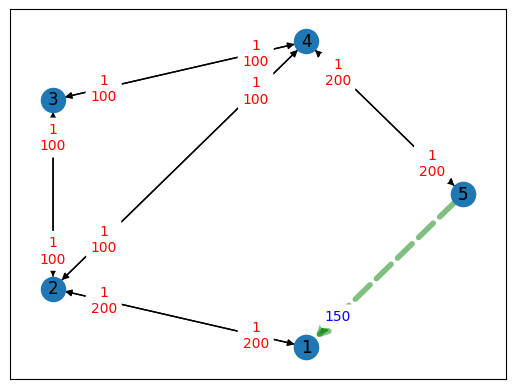

In [9]:
instance.draw(capacity_name="bandwidth")
plt.show()

In [10]:
# Reduce the size of the graph
from contraction_test import contract_graph
exclude_nodes = demands[0,:2].tolist()
G_contract, demands_contract, node_map = contract_graph(G, demands, exclude_nodes=exclude_nodes)
instance_contract = MCNF(G_contract, demands_contract)

/home/aschulz/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is multigraph  True
comp  {3}
	neighs :  [2, 4] 2
	extremities  [3] 1
Chain :  [4, 3, 2]
[1, 1]
[100, 100]


(5, 4, 0) {'cost': 1, 'bandwidth': 200}
(4, 2, 0) {'cost': 1, 'bandwidth': 100}
(4, 2, 1) {'cost': 2.0, 'bandwidth': 100, 'type': 'chain', 'chain': [(4, 3, 0), (3, 2, 0)]}
(4, 5, 0) {'cost': 1, 'bandwidth': 200}
(2, 1, 0) {'cost': 1, 'bandwidth': 200}
(2, 4, 0) {'cost': 1, 'bandwidth': 100}
(2, 4, 1) {'cost': 2.0, 'bandwidth': 100, 'type': 'chain', 'chain': [(2, 3, 0), (3, 4, 0)]}
(1, 2, 0) {'cost': 1, 'bandwidth': 200}


<AxesSubplot:>

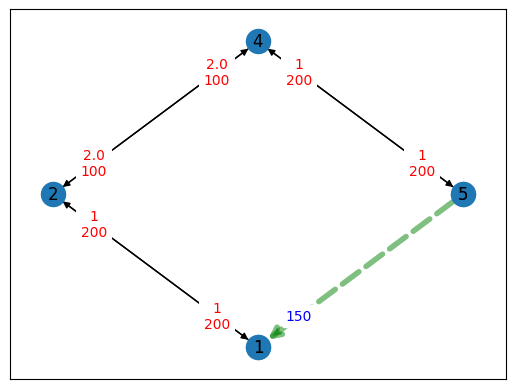

In [11]:
for e in G_contract.edges:
    print(e, G_contract.edges[e])
instance_contract.draw()

In [12]:
# solve the problem on the contracted graph
status_c, solution_c, solve_t = instance_contract.solve_with_cplex(capacity="bandwidth")
print(solution_c)

[150. 100.  50.   0. 150.   0.   0.   0.]


In [13]:
# get the paths used on the contracted graph
paths_c, flows_c = instance_contract.solution_paths(solution_c)
for k,demand in enumerate(demands_contract):
    print("demand", k, demand)
    for path,flow in zip(paths_c[k], flows_c[k]):
        print("\t",path,flow)

demand 0 [  5   1 150]
	 Path ([(5, 4, 0), (4, 2, 0), (2, 1, 0)]) 100.0
	 Path ([(5, 4, 0), (4, 2, 1), (2, 1, 0)]) 50.0


In [23]:
# reconstruct the paths on the original graph
def repair_path(path, graph):
    nedges = []
    for e in path.edges:
        chain = graph.edges[e].get("chain",None)
        if chain:
            nedges += chain
        else:
            nedges += [e]
    return Path(edges=nedges)
for path in paths_c[0]:
    npath = repair_path(path, G_contract)
    print(npath)

Path ([(5, 4, 0), (4, 2, 0), (2, 1, 0)])
Path ([(5, 4, 0), (4, 3, 0), (3, 2, 0), (2, 1, 0)])


In [26]:
# solution of the original problem
status, sol, t = instance.solve_with_cplex(capacity="bandwidth")
paths_o, flows_o = instance.solution_paths(sol)
for k,demand in enumerate(demands):
    print(k, demand)
    for path,flow in zip(paths_o[k], flows_o[k]):
        print("\t",path,flow)

0 [  5   1 150]
	 Path ([(5, 4, 0), (4, 3, 0), (3, 2, 0), (2, 1, 0)]) 50.0
	 Path ([(5, 4, 0), (4, 2, 0), (2, 1, 0)]) 100.0
